In [ ]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [185]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("../../Desktop/deepOF_CSDS_tutorial_dataset/"),
                arena="circular-manual",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=True,
                exp_conditions={
                    '20191204_Day2_SI_JB08_Test_56': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_61': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_62': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
                }
)

# Set manually the edge in the polygons that we're measuring

In [186]:
my_deepof_project = my_deepof_project.run()

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...


KeyboardInterrupt: 

In [91]:
# Save your project to avoid laborious repetitions

In [92]:
my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

In [188]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1667951748.pkl")

In [199]:
# TODO: average all selected videos
# TODO: Operate with videos (ie substract one averaged condition from another)

['20191204_Day2_SI_JB08_Test_54',
 '20191204_Day2_SI_JB08_Test_63',
 '20191204_Day2_SI_JB08_Test_64']

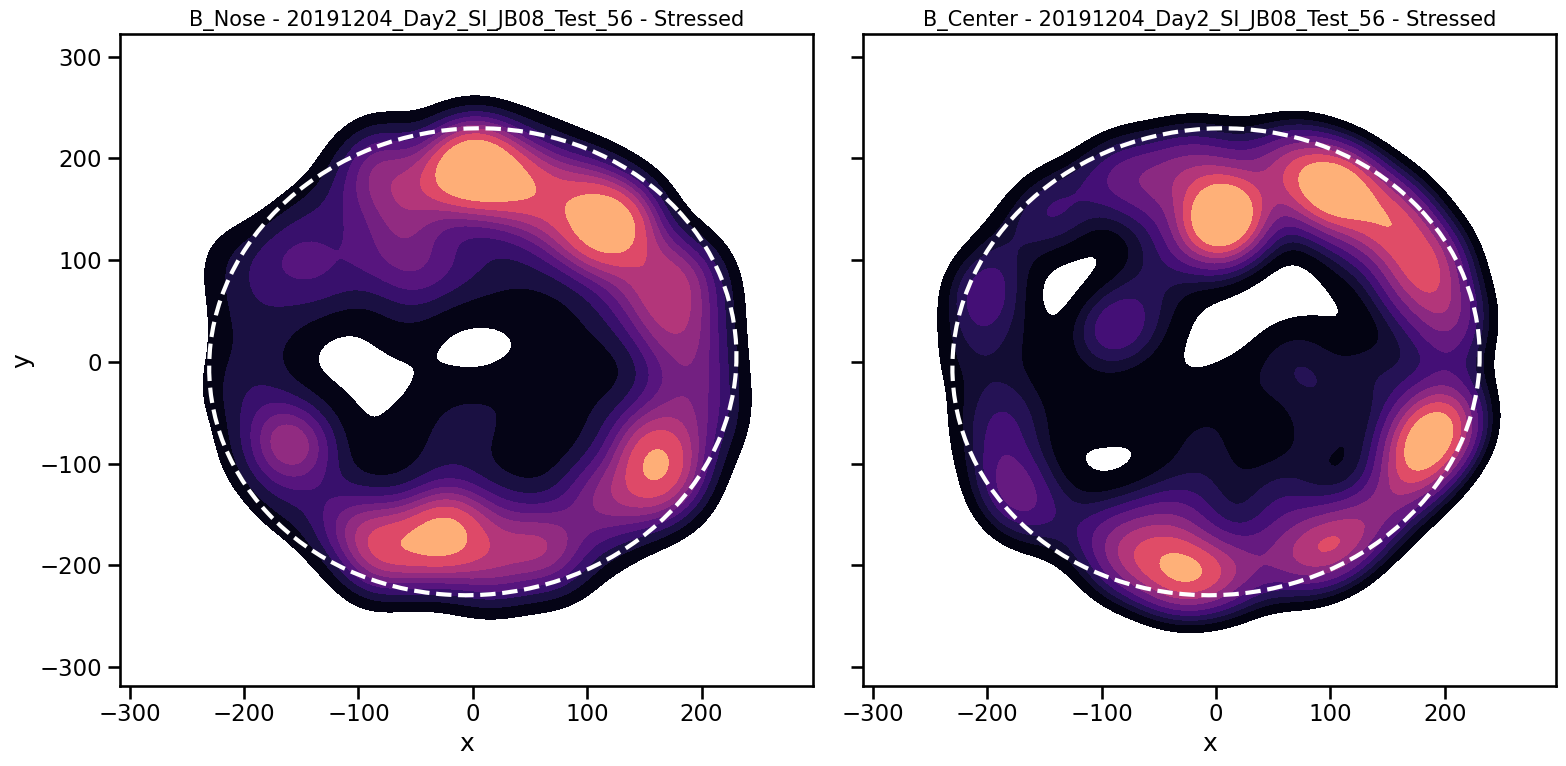

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

deepof.visuals.plot_heatmaps(my_deepof_project, ["B_Nose", "B_Center"], center="arena", i=0, exp_condition="Stressed", show=False)

plt.tight_layout()
plt.show()

In [282]:
# Explore and visualize the data as heatmaps (heatmaps)
# Plot static and animated trajectories (skeleton-based)
# Plot static and animated embeddings (PCA, raw UMAP)

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=200,
)

html = display.HTML(video)
display.display(html)
plt.close()

# TODO: Fix colors! and add legened

In [353]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
# Show how to merge different feature objects